In [2]:
import sdepy
import numpy as np
import mplfinance as mpf
import requests
import json
import pandas as pd
import yfinance as yf
import quandl

ALPHAVANTAGE_API = '70017SWTZQFMZIJ6'
NASDAQ_API = '8P6FhFbwtrNzUMVbCkwz'

In [3]:
def check_stock_symbol(symbol):
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        # If the API returns a name, we assume the symbol is valid
        if 'shortName' in info:
            return f"{symbol} is a valid stock symbol: {info['shortName']}"
        else:
            return f"{symbol} is not a valid stock symbol"
    except Exception as e:
        return f"Error checking {symbol}: {e}"


In [4]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
def get_stocks_data(symbol, month):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&month={month}&interval=1min&apikey={ALPHAVANTAGE_API}&outputsize=full'
    r = requests.get(url)
    print(r.json())
    data = r.json()["Time Series (1min)"]
    df = pd.DataFrame([data[elem] for elem in data])
    df.rename(columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
    }, inplace=True)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(int)

    df['Date'] = data.keys()
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    return(df)


#def get_stocks_data(symbol, start, end, interval="90m"):
#    return(yf.download(symbol, start=start, end=end, interval=interval))

#def get_stocks_data(symbol, start, end, interval="1h"):
#    quandl.ApiConfig.api_key = '8P6FhFbwtrNzUMVbCkwz'
#    data = quandl.get(f"WIKI/{symbol}", start_date=start, end_date=end) 
#    return(data)


In [5]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
import numpy as np

def lowess_estimation(time_series, frac=0.2):
    lowess_result = sm.nonparametric.lowess(time_series.values, np.arange(len(time_series)), frac=frac)
    return lowess_result[:, 1]  # return the smoothed values
    
def lowess_std(time_series, frac=0.2):
    smoothed_values = lowess_estimation(time_series, frac)
    residuals = time_series.values - smoothed_values
    return np.abs(residuals)

def create_continuous_function(x_values, y_values, kind='linear'):
    return interp1d(x_values, y_values, kind=kind, fill_value="extrapolate")

In [6]:
df = get_stocks_data('AAPL', "2021-09")
df_train = df.head(-100)
df_test = df.tail(100)

{'Meta Data': {'1. Information': 'Intraday (1min) open, high, low, close prices and volume', '2. Symbol': 'AAPL', '3. Last Refreshed': '2021-09-30 19:59:00', '4. Interval': '1min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}, 'Time Series (1min)': {'2021-09-30 19:59:00': {'1. open': '139.3652', '2. high': '139.3652', '3. low': '139.2669', '4. close': '139.2768', '5. volume': '2533'}, '2021-09-30 19:58:00': {'1. open': '139.3357', '2. high': '139.3652', '3. low': '139.3259', '4. close': '139.3259', '5. volume': '2705'}, '2021-09-30 19:57:00': {'1. open': '139.3062', '2. high': '139.3357', '3. low': '139.2769', '4. close': '139.3357', '5. volume': '6225'}, '2021-09-30 19:56:00': {'1. open': '139.2768', '2. high': '139.3161', '3. low': '139.2768', '4. close': '139.3161', '5. volume': '1350'}, '2021-09-30 19:55:00': {'1. open': '139.2866', '2. high': '139.3161', '3. low': '139.2669', '4. close': '139.3161', '5. volume': '1330'}, '2021-09-30 19:54:00': {'1. open': '139.2767

In [7]:
def make_cangle_plot(df):
    mpf.plot(df, type='candle', style='charles', volume=True, title='Sample Stock Data', ylabel='Price')


/home/leo/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


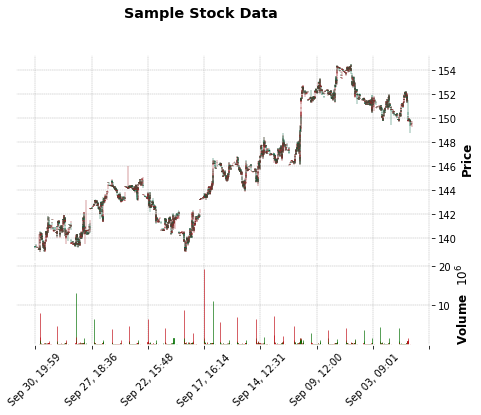

In [8]:
make_cangle_plot(df)

In [9]:
check_stock_symbol('JAZZ')

'JAZZ is a valid stock symbol: Jazz Pharmaceuticals plc'

First example making stocks model. Most simple model - static mean and std

In [10]:
@sdepy.integrate
def my_process(t, x):
    return {'dt': df_train["High"].mean(), 'dw':  df_train["High"].std()}

P = my_process(x0=1, paths=100, steps=100)
x = P(timeline=(0., 0.5, 1.))
np.mean((x[2] - df_test["High"])**2)

30.875129170662017

Modelling by LOWESS regression

In [11]:
x = ((df_train.index - pd.Timestamp("2021-09-01"))// pd.Timedelta('1m')).values.astype(float)
a = create_continuous_function(x, lowess_estimation(df_train["High"], frac=0.6), kind='cubic')
b = create_continuous_function(x, lowess_std(df_train["High"], frac=0.6), kind='cubic')

@sdepy.integrate
def my_process(t, x):
    return {'dt': a(t), 'dw':  b(t)}

P = my_process(x0=1, paths=100, steps=100)
x1 = P(timeline=(400., 500., 600.))
np.mean((x1[1] - df_test["High"])**2)

506830992.5859602

In [12]:
x

array([42959., 42958., 42957., ...,   465.,   464.,   463.])

Prediction for next-day data

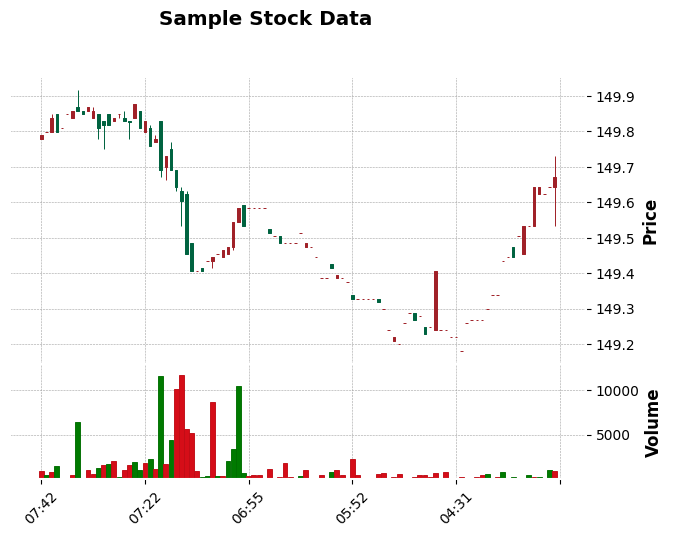

In [13]:
make_cangle_plot(df_test)

In [1]:
!pip install ta

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=62c1b30336f172b71d9a1f3e6114422df095aff5706f176d41c34860a0707607
  Stored in directory: /home/leo/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


Computation of some tech. analisys metrics

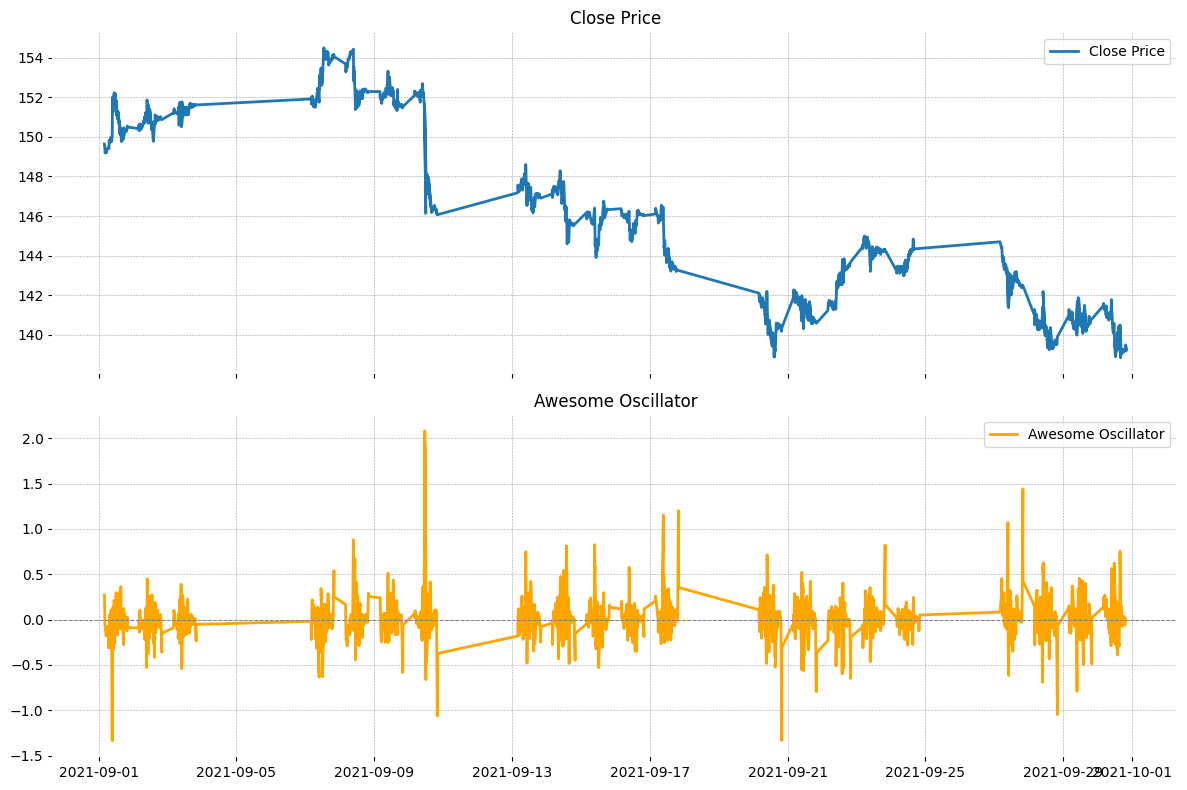

In [40]:
import ta

import matplotlib.pyplot as plt
ao_indicator = ta.momentum.AwesomeOscillatorIndicator(df["High"], df["Low"])

df['Awesome_Oscillator'] = ao_indicator.awesome_oscillator()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the close price
ax[0].plot(df['Close'], label='Close Price')
ax[0].set_title('Close Price')
ax[0].legend()

# Plot the Awesome Oscillator
ax[1].plot(df['Awesome_Oscillator'], color='orange', label='Awesome Oscillator')
ax[1].axhline(0, color='gray', linestyle='--', linewidth=0.7)
ax[1].set_title('Awesome Oscillator')
ax[1].legend()

plt.tight_layout()
plt.show()

In [43]:
#Find signals

df['Awesome_Oscillator'][df['Awesome_Oscillator'] > 1]

Date
2021-09-27 19:56:00    1.234483
2021-09-27 19:55:00    1.443600
2021-09-27 19:54:00    1.400585
2021-09-27 19:53:00    1.354968
2021-09-27 19:52:00    1.312086
                         ...   
2021-09-10 11:02:00    1.362237
2021-09-10 11:01:00    1.303544
2021-09-10 11:00:00    1.234751
2021-09-10 10:59:00    1.141704
2021-09-10 10:58:00    1.037156
Name: Awesome_Oscillator, Length: 62, dtype: float64

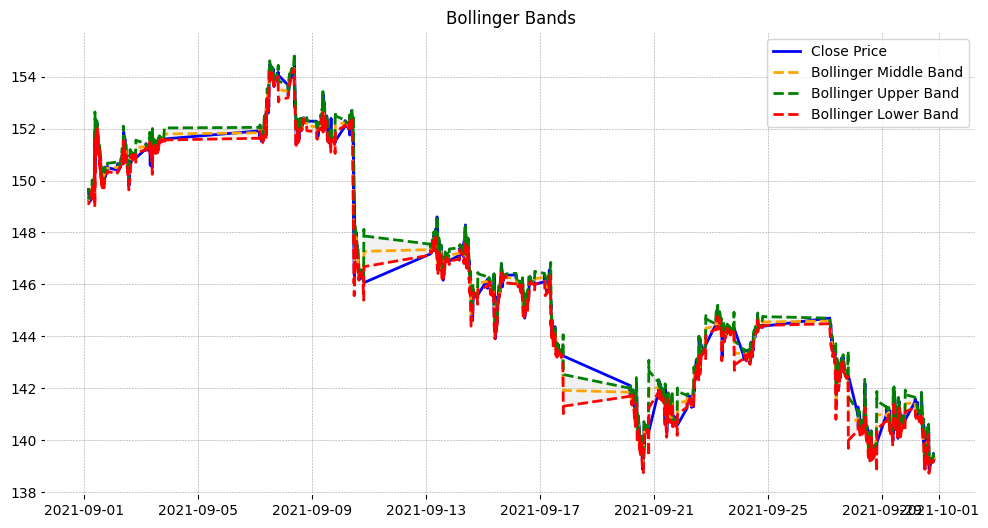

In [45]:
bb_indicator = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)

# Calculate Bollinger Bands values
df['BB_Middle'] = bb_indicator.bollinger_mavg()
df['BB_Upper'] = bb_indicator.bollinger_hband()
df['BB_Lower'] = bb_indicator.bollinger_lband()

# Plotting
plt.figure(figsize=(12, 6))

# Plot close price
plt.plot(df['Close'], label='Close Price', color='blue')

# Plot Bollinger Bands
plt.plot(df['BB_Middle'], label='Bollinger Middle Band', color='orange', linestyle='--')
plt.plot(df['BB_Upper'], label='Bollinger Upper Band', color='green', linestyle='--')
plt.plot(df['BB_Lower'], label='Bollinger Lower Band', color='red', linestyle='--')

# Fill the area between upper and lower bands
plt.fill_between(df.index, df['BB_Upper'], df['BB_Lower'], color='lightgray', alpha=0.3)

plt.title('Bollinger Bands')
plt.legend()
plt.show()

In [46]:
# Find signals

df[df['Close'] > df['BB_Upper']]

,Open,High,Low,Close,Volume,Awesome_Oscillator,BB_Middle,BB_Upper,BB_Lower
Date,,,,,,,,,
2021-09-30 19:32:00,139.3947,139.4241,139.3947,139.4241,237,NaN,139.292480,139.397985,139.186975
2021-09-30 19:28:00,139.3652,139.4929,139.3161,139.4929,2066,NaN,139.321465,139.453933,139.188997
2021-09-30 17:29:00,139.2669,139.2768,139.2669,139.2768,575,0.018643,139.216825,139.275413,139.158237
2021-09-30 16:30:00,139.1294,139.1294,139.1196,139.1196,2664,0.019469,139.069460,139.118344,139.020576
2021-09-30 16:29:00,139.1097,139.1392,139.1097,139.1392,2729,0.029147,139.072900,139.130475,139.015325
...,...,...,...,...,...,...,...,...,...
2021-09-01 04:14:00,149.4356,149.4356,149.4356,149.4356,824,0.041952,149.271070,149.376126,149.166014
2021-09-01 04:13:00,149.4455,149.4455,149.4455,149.4455,111,0.076609,149.280405,149.409801,149.151009
2021-09-01 04:12:00,149.4455,149.4749,149.4455,149.4749,323,0.107005,149.289735,149.444487,149.134983


In [ ]:
# Find signals

df[df['Close'] < df['BB_Lower']]